# Gradient Boosting with Random Forests and related topics

In this last notebook, we will explore the Gradient Boosting technique for classification. This technique combines the principles of gradient boosting and random forests by sequentially fitting decision trees to the errors of the previous trees, improving model accuracy while maintaining the benefits of ensemble methods.

### Import and preprocess data

In [2]:
#IMPORTS PACKAGES
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [3]:
path = os.path.join(os.getcwd(), 'EEG_mouse_data.csv')
data_mice = pd.read_csv(path)

In [4]:
def norm_0_1(data):
    # Calculate the minimum and maximum values for each column (feature)
    min_vals = data.min(axis=0)
    max_vals = data.max(axis=0)
    #print(max_vals)
    
    # Perform min-max scaling
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data


#CREATE X AND Y FROM DATAFRAME
X = np.vstack([data_mice.iloc[i, 2:] for i in np.arange(len(data_mice))])
X = norm_0_1(X)
Y = data_mice['state'].values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### GradientBoostingClassifier

This time, the hyperparameters have already been fine-tuned, so you don't need to adjust them yourself. Simply execute the cell to train the model; it might take 1 or 2 minutes.

Q3.1: Two additional hyperparameters were added compared to the RandomForestClassifier. What are these hyperparameters, and what roles do they play?

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

# Define hyperparameters for Gradient Boosting
hyperparameters_gb = {
    'n_estimators': 300,
    'learning_rate': 0.05, 
    'max_depth': 4,         
    'subsample': 0.5,
    'min_samples_leaf': 15,
    'max_features': 20,
}

# Create a Gradient Boosting classifier with the specified hyperparameters
gb_classifier = GradientBoostingClassifier(**hyperparameters_gb,random_state=0)

# Fit the model on the training data
gb_classifier.fit(X_train, Y_train)
print('Gradient Boosting model trained')

Gradient Boosting model trained


The two additional hyperparameters are:

- learning_rate (0.05): Controls the contribution of each tree to the final prediction. A lower learning rate means each tree has less influence, requiring more trees but typically leading to better generalization and reduced overfitting. It shrinks the contribution of each tree by this factor.

- subsample (0.5): The fraction of samples to be used for fitting each individual tree. Setting it to 0.5 means only 50% of the training data is randomly sampled for each tree. This helps prevent overfitting as well.

### FINAL MODEL EVALUATION

Accuracy on Training Set: 0.9564975934838948
Accuracy on Test Set: 0.9111549851924975
Classification Report for Training Set:
              precision    recall  f1-score       support
n              0.956192  0.964212  0.960186   5365.000000
r              0.953608  0.689013  0.800000   1074.000000
w              0.956886  0.981673  0.969121   9767.000000
accuracy       0.956498  0.956498  0.956498      0.956498
macro avg      0.955562  0.878300  0.909769  16206.000000
weighted avg   0.956439  0.956498  0.954955  16206.000000
Classification Report for Test Set:
              precision    recall  f1-score      support
n              0.916968  0.922965  0.919957  1376.000000
r              0.735099  0.409594  0.526066   271.000000
w              0.918521  0.960915  0.939240  2405.000000
accuracy       0.911155  0.911155  0.911155     0.911155
macro avg      0.856863  0.764491  0.795088  4052.000000
weighted avg   0.905726  0.911155  0.905058  4052.000000


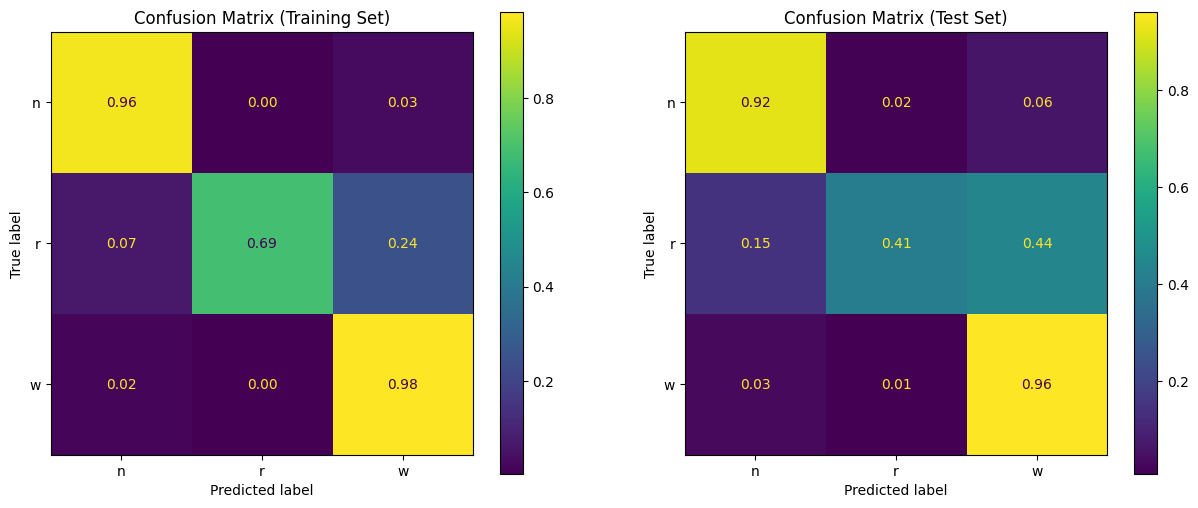

In [9]:
# Make predictions
train_prediction = gb_classifier.predict(X_train)
test_prediction = gb_classifier.predict(X_test)
test_prediction

# Calculate accuracy
train_accuracy = accuracy_score(Y_train, train_prediction)
test_accuracy = accuracy_score(Y_test, test_prediction)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Confusion matrix for the training set
cm_train = confusion_matrix(Y_train, train_prediction, normalize='true')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=gb_classifier.classes_)
_=disp_train.plot(ax=axs[0], values_format=".2f")
_=axs[0].set_title('Confusion Matrix (Training Set)')
# Confusion matrix for the test set
cm_test = confusion_matrix(Y_test, test_prediction, normalize='true')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=gb_classifier.classes_)
_=disp_test.plot(ax=axs[1], values_format=".2f")
_=axs[1].set_title('Confusion Matrix (Test Set)')

# Display accuracy for both sets
print('Accuracy on Training Set:', train_accuracy)
print('Accuracy on Test Set:', test_accuracy)

# Classification report for the training set
classification_metrics_train = classification_report(Y_train, train_prediction, output_dict=True)
report_df_train = pd.DataFrame(classification_metrics_train).transpose()
print("Classification Report for Training Set:")
print(report_df_train)

# Classification report for the test set
classification_metrics_test = classification_report(Y_test, test_prediction, output_dict=True)
report_df_test = pd.DataFrame(classification_metrics_test).transpose()
print("Classification Report for Test Set:")
print(report_df_test)

plt.show()

The cell above summarizes performance of the GradientBoostingClassifier.

Q3.2: Comment the results. Compare these results with the ones obtained with the RandomForestClassifier. Compare more specifically the precision, the recall and the f1-score of the 'r' class obtained with GradientBoostingClassifier and RandomForestClassifier. What are your conclusions?

Gradient Boosting shows improved performance on the minority 'r' class compared to Random Forest. This is because the sequential learning approach of Gradient Boosting focuses on correcting previous errors, which is beneficial for the underrepresented REM sleep class.

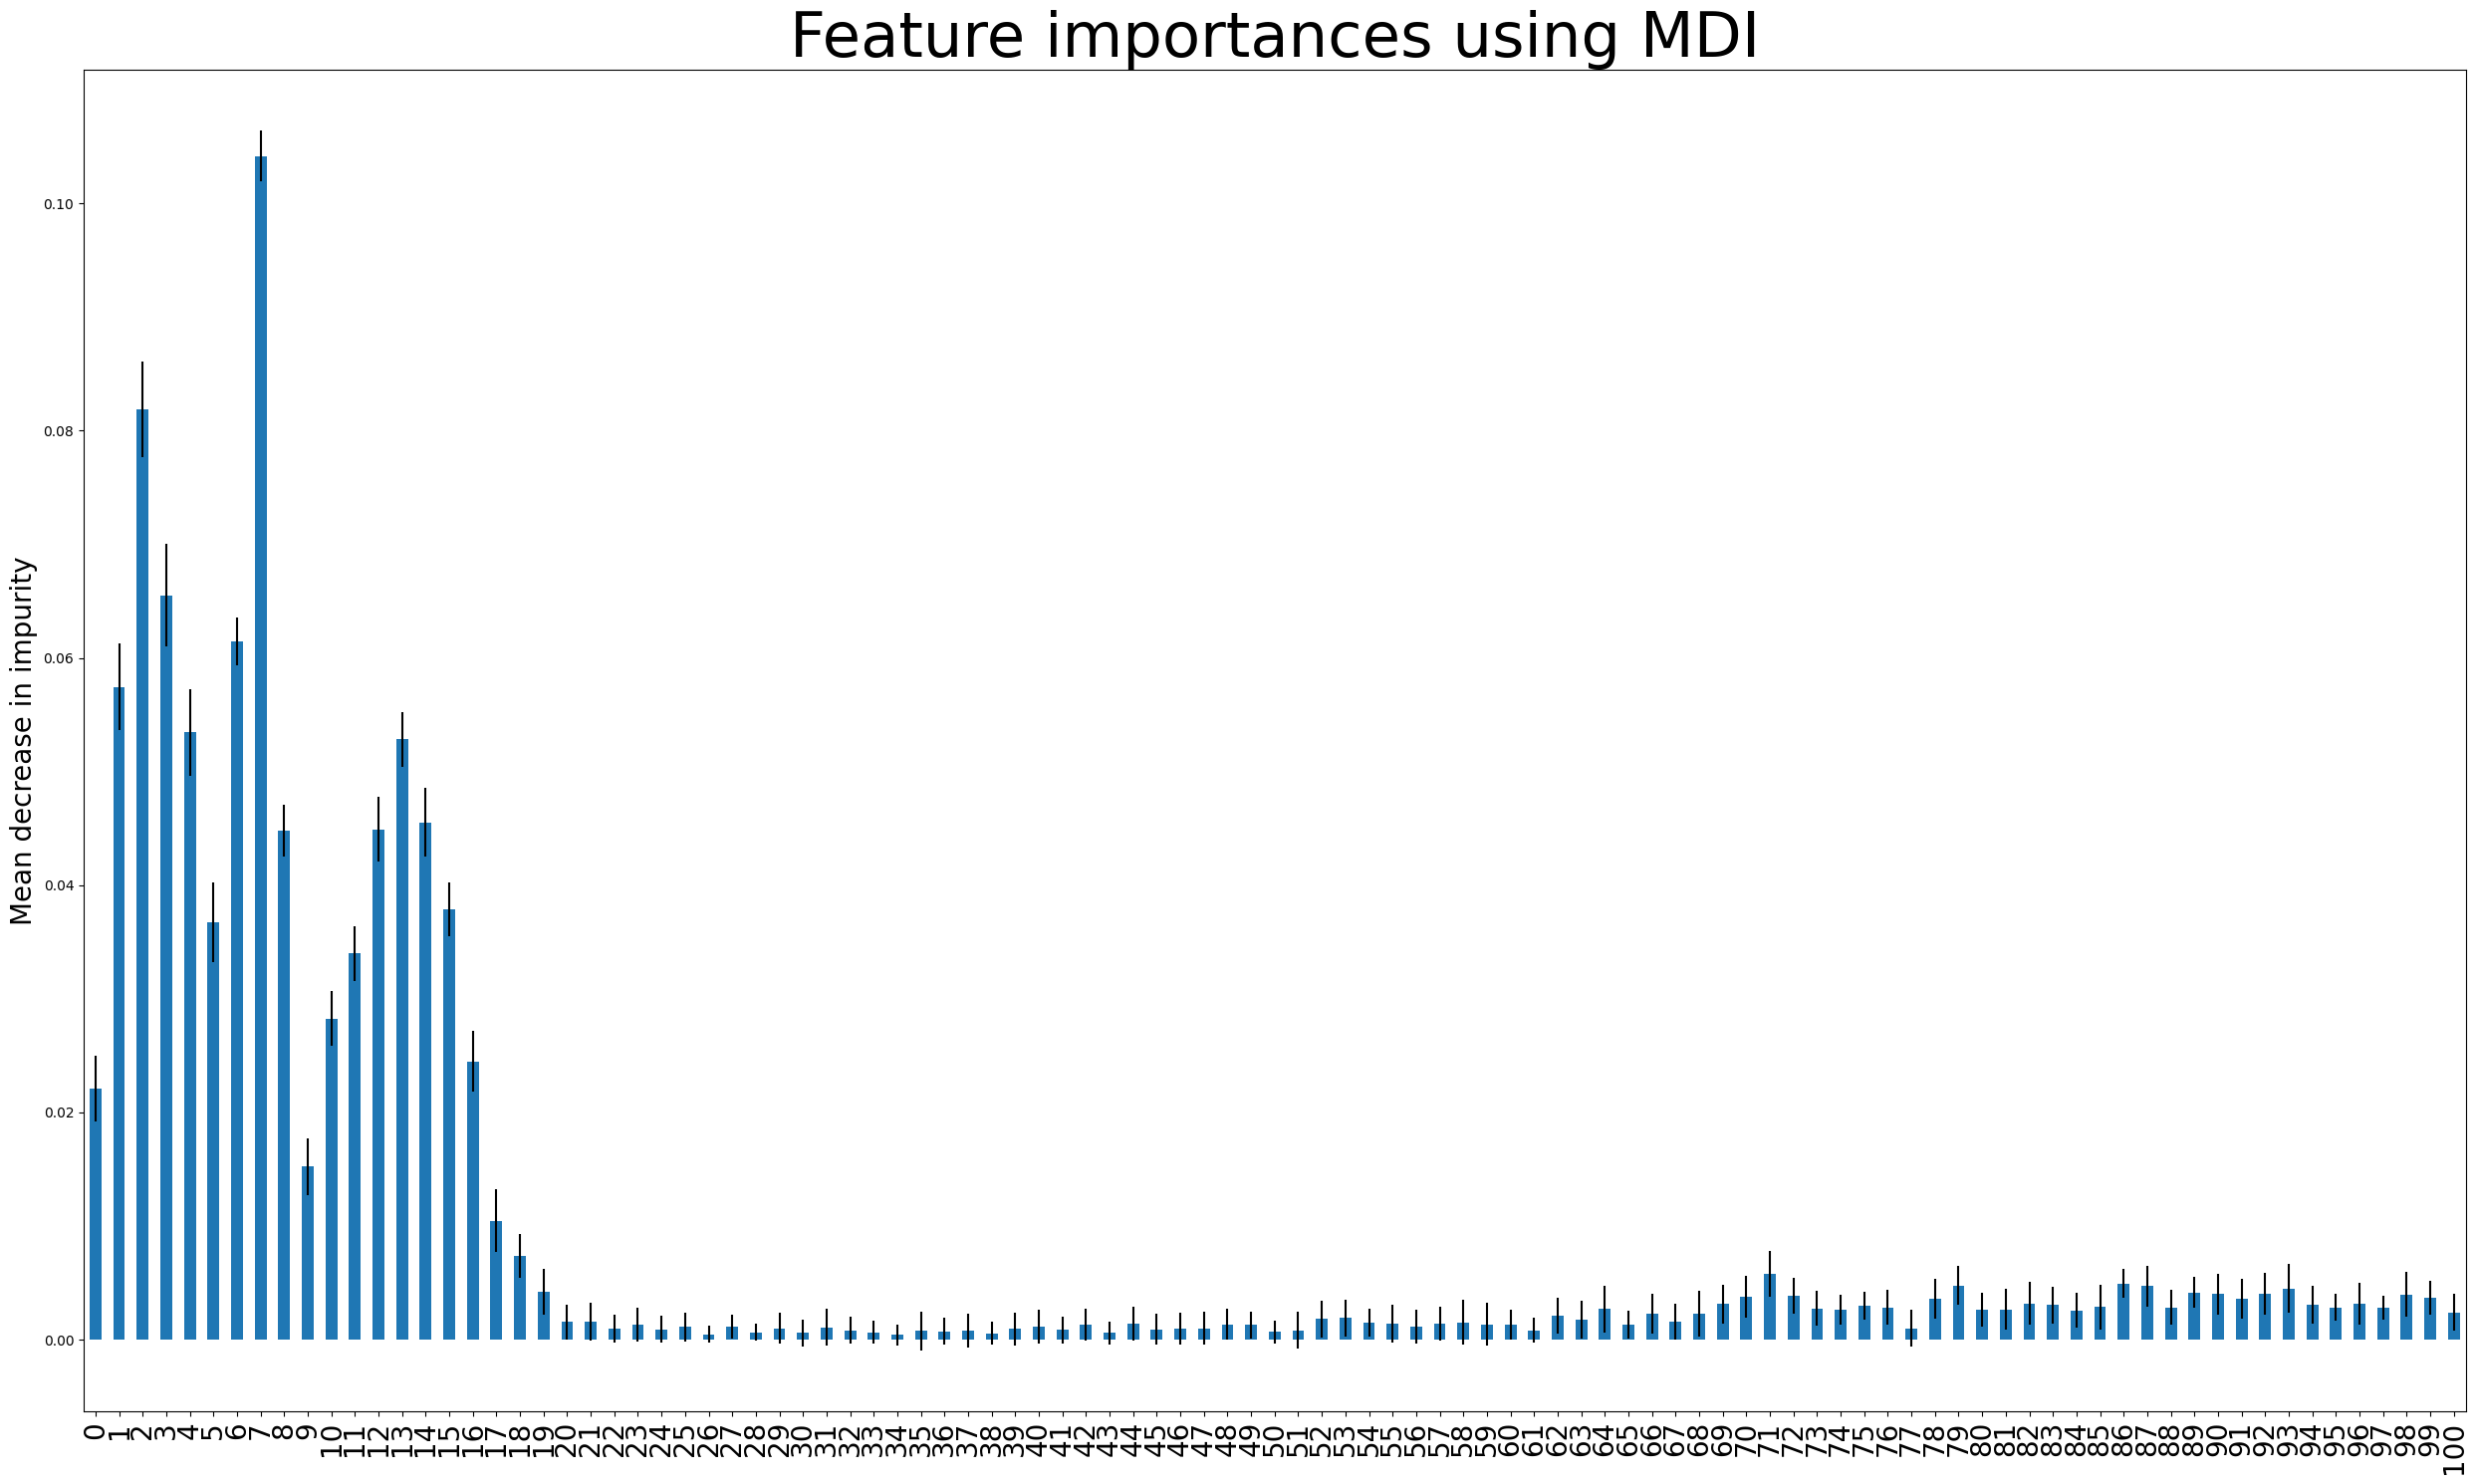

In [10]:
### FEATURES IMPORTANCE

# Calculate feature importances and SEM
importances = gb_classifier.feature_importances_
n_trees = len(gb_classifier.estimators_)
std = np.std([tree[0].feature_importances_ for tree in gb_classifier.estimators_], axis=0)
sem = std / np.sqrt(n_trees)

# Plot features importance
forest_importances = pd.Series(importances)
fig, ax = plt.subplots(figsize=(25, 15))
plt.xticks(rotation=90, fontsize=20)
forest_importances.plot.bar(ax=ax, yerr=sem)  # Use SEM for error bars
ax.set_title("Feature importances using MDI", fontsize=45)
ax.set_ylabel("Mean decrease in impurity", fontsize=20)
fig.tight_layout()

NOTE: It is interesting to note that, in a real-world scenario, performances for this task could be further improved. For example, you could apply more advanced feature engineering techniques, or even incorporate other sensors, such as an electromyograph (EMG) for recording the electrical activity in skeletal muscles. Nevertheless, these aspects are beyond the scope of this practical work.